<center><img src="https://raw.githubusercontent.com/openvinotoolkit/anomalib/main/docs/source/images/logos/anomalib-wide-blue.png" alt="Paris" class="center"></center>

<center>💙 A library for benchmarking, developing and deploying deep learning anomaly detection algorithms</center>

---

> NOTE:
> This notebook is originally created by @innat on [Kaggle](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook).

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) and [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA) for **benchmarking** and `folder` for custom dataset **training/inference**. In this notebook, we will explore `anomalib` training a PADIM model on the `MVTec AD` bottle dataset and evaluating the model's performance. The sections in this notebook explores the steps in `tools/train.py` more in detail. Those who would like to reproduce the results via CLI could use `python tools/train.py --model padim`.


## Installing Anomalib


Installation can be done in two ways: (i) install via PyPI, or (ii) installing from sourc, both of which are shown below:


### I. Install via PyPI


In [22]:
# Option - I: Uncomment the next line if you want to install via pip.
# %pip install anomalib

### II. Install from Source

This option would initially download anomalib repository from github and manually install `anomalib` from source, which is shown below:


In [23]:
# Option - II: Uncomment the next three lines if you want to install from the source.
# !git clone https://github.com/openvinotoolkit/anomalib.git
# %cd anomalib
# %pip install .

Now let's verify the working directory. This is to access the datasets and configs when the notebook is run from different platforms such as local or Google Colab.


In [24]:
import os
from pathlib import Path

from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "000_getting_started":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/000_getting_started/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    root_directory = current_directory / "anomalib"

os.chdir(root_directory)

## Imports


In [25]:
from typing import Any
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from anomalib.engine import Engine
from torchvision.transforms import ToPILImage

from anomalib.data import MVTec
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer, ExportType
from anomalib.models import Padim
from anomalib import TaskType

## Model

Currently, there are **13** anomaly detection models available in `anomalib` library. Namely,

- [CFA](https://arxiv.org/abs/2206.04325)
- [CS-Flow](https://arxiv.org/abs/2110.02855v1)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [DRAEM](https://arxiv.org/abs/2108.07610)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Reverse Distillation](https://arxiv.org/abs/2201.10703)
- [R-KDE](https://ieeexplore.ieee.org/document/8999287)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using [Padim](https://arxiv.org/pdf/2011.08785.pdf).


## Dataset: MVTec AD

**MVTec AD** is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over **5000** high-resolution images divided into **15** different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects. If the dataset is not located in the root datasets directory, anomalib will automatically install the dataset.

We could now import the MVtec AD dataset using its specific datamodule implemented in anomalib.


In [26]:
datamodule = MVTec()
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


Let's check the shapes of the input images and masks.


In [27]:
print(data["image"].shape, data["mask"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])


We could now visualize a normal and abnormal sample from the validation set.


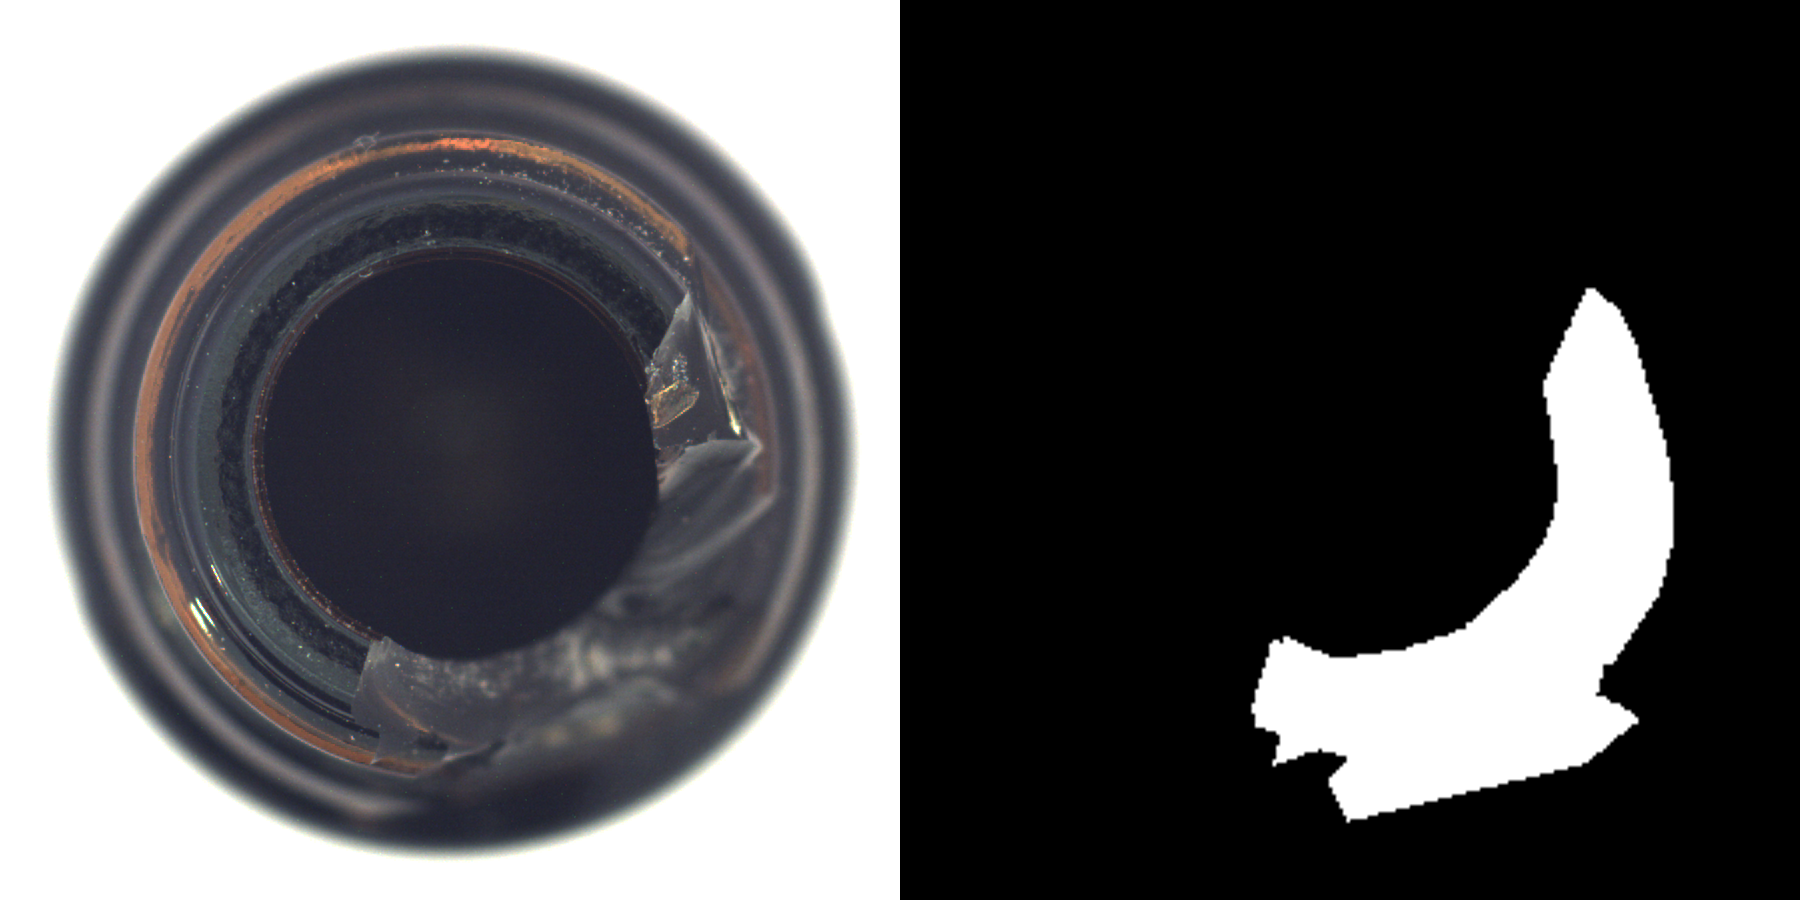

In [28]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    """Show an image with a mask.

    Args:
        sample (dict[str, Any]): Sample from the dataset.
        index (int): Index of the sample.

    Returns:
        Image: Output image with a mask.
    """
    # Load the image from the path
    image = Image.open(sample["image_path"][index])

    # Load the mask and convert it to RGB
    mask = ToPILImage()(sample["mask"][index]).convert("RGB")

    # Resize mask to match image size, if they differ
    if image.size != mask.size:
        mask = mask.resize(image.size)

    return Image.fromarray(np.hstack((np.array(image), np.array(mask))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

## Prepare Model

Let's create the Padim and train it.

In [29]:
# Get the model
model = Padim()

In [30]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:180: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | model                 | PadimModel               | 2.8 M 
1 | normalization_metri

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Validation


In [31]:
# load best model from checkpoint before evaluating
test_results = engine.test(
    model=model,
    datamodule=datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

Restoring states from the checkpoint path at /home/abogusze/repos/anomalib/lightning_logs/version_3/checkpoints/epoch=0-step=7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/abogusze/repos/anomalib/lightning_logs/version_3/checkpoints/epoch=0-step=7.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

## OpenVINO Inference

Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.


Before we can use OpenVINO inference, let's export the model to OpenVINO format first.

In [32]:
engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    datamodule=datamodule,
    input_size=(256, 256),
)

/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/torch/onnx/utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit

PosixPath('/home/abogusze/repos/anomalib/weights/openvino/model.xml')

### Load a Test Image

Let's read an image from the test set and perform inference using OpenVINO inferencer.


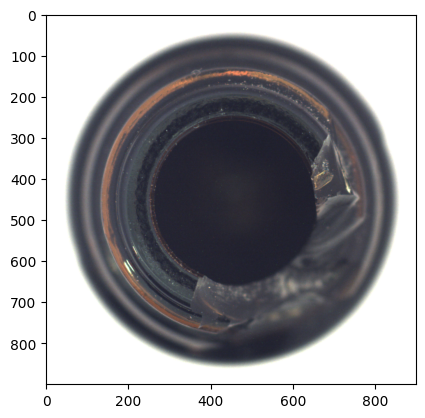

In [33]:
image_path = root_directory / "datasets/MVTec/bottle/test/broken_large/000.png"
image = read_image(path="./datasets/MVTec/bottle/test/broken_large/000.png")
plt.imshow(image)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.


In [34]:
output_path = Path(engine.trainer.default_root_dir)
print(output_path)

/home/abogusze/repos/anomalib


In [35]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
metadata = output_path / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata.exists())

True True


In [36]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference

Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.


In [37]:
print(image.shape)

(900, 900, 3)


In [38]:
predictions = inferencer.predict(image=image)

where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.


### Visualizing Inference Results


In [39]:
print(predictions.pred_score, predictions.pred_label)

0.749733522803499 True


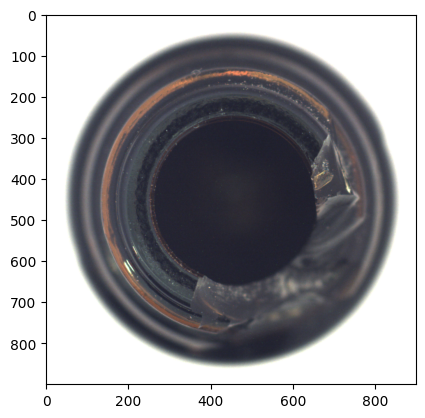

In [40]:
# Visualize the original image
plt.imshow(predictions.image)

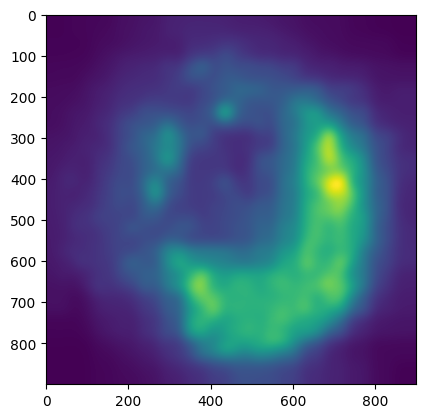

In [41]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)

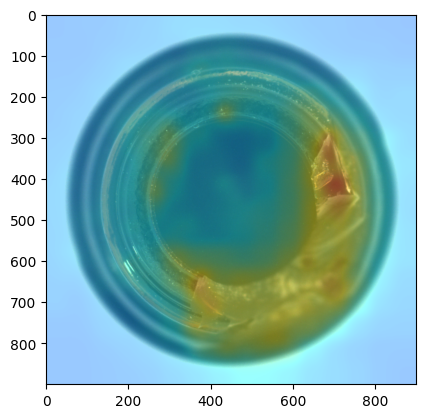

In [42]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

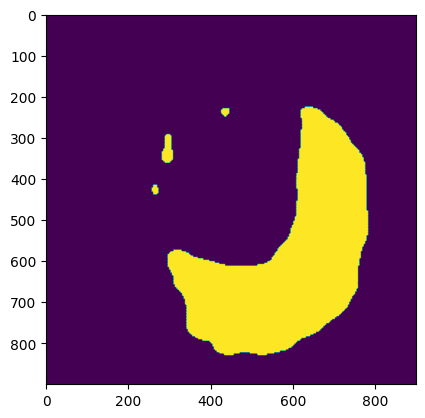

In [43]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

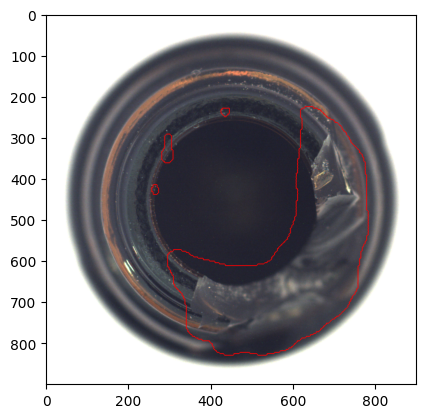

In [44]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)

This wraps the `getting_started` notebook. There are a lot more functionalities that could be explored in the library. Please refer to the [documentation](https://openvinotoolkit.github.io/anomalib/) for more details.
